# Creating a Neural Network From Scratch

## Creating neurons and batches

In [1]:
import numpy as np
from fontTools.misc.bezierTools import epsilon
from jupyter_client.consoleapp import classes

#Input is as batches of 4
inputs = np.array([[1.0, 2.0, 3.0, 2.5], 
                   [2.0, 5.0, -10, 2.0],
                   [-1.5, 2.7, 3.3, -0.8]])
weights = [[0.2, 0.8, -0.5, 1.0],
[0.5, -0.91, 0.26, -0.5],
[-0.26, -0.27, 0.17, 0.87]]

biases = [2.0, 3.0, 0.5]

layer_out = np.dot(inputs, np.array(weights).T) + biases
print(layer_out)

[[ 4.8    1.21   2.385]
 [13.4   -4.15  -1.33 ]
 [ 1.41   1.051  0.026]]


## Creating Dense Layers Using Multiple Neurons and Input Batches

To add a dense layer we need to take an input matrix, initialise a weight matrix according to the number of the in[uts and number of neurons.
Here, we’re setting weights to be random and biases to be 0. Note that we’re initializing weights to be (inputs, neurons), rather than (neurons, inputs). We’re doing this ahead instead of transposing every time we perform a forward pass. Initially we are choosing our bias as 0.

In [2]:
import nnfs
from nnfs.datasets import spiral_data

class DenseLayer:
    def __init__(self, n_inp, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inp, n_neurons)
        self.bias = np.zeros((1, n_neurons))
        
    def forward_pass(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.bias
        

## Adding necessary Activation Functions

### Rectified Linear Unit or ReLu Activation Function

ReLu functions return the number itself if the number is positive or zero otherwise.
The Graph of ReLu Function is given

Text(0, 0.5, 'ReLu')

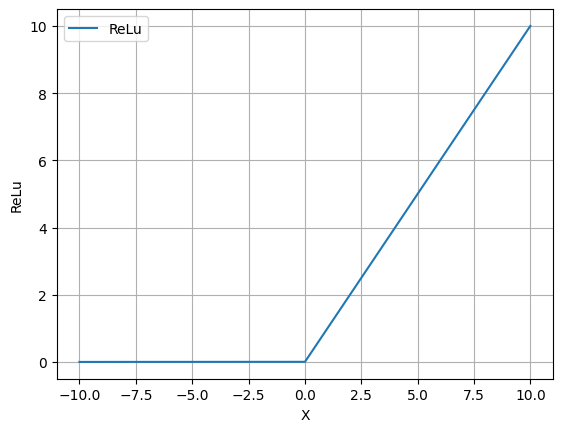

In [3]:
import matplotlib.pyplot as plt

X = np.linspace(-10, 10, 10000)
Y = np.maximum(0, X)

plt.plot(X, Y, label='ReLu')
plt.grid()
plt.legend()
plt.xlabel('X')
plt.ylabel('ReLu')

### Implementing Relu

In [4]:
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

class ReLu_Activation:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
       
       
#Importing Dataset to Test. 
X, y = spiral_data(samples=100, classes=3)

dense1 = DenseLayer(2, 3)

activation1 = ReLu_Activation()

dense1.forward_pass(X)

activation1.forward(dense1.output)

print(activation1.output[:5])

[[0.         0.         0.        ]
 [0.         0.00011395 0.        ]
 [0.         0.00031729 0.        ]
 [0.         0.00052666 0.        ]
 [0.         0.00071401 0.        ]]


### Softmax Activation

In SoftMax Activation Function we first exponentiate the outputs ( E ^ output_values). and then take a given exponentiated value and divide it by the sum of all of the exponentiated values in the output. Since each output value normalizes to a fraction of the sum, all the values are now in the range of 0 to 1 and add up to 1 — they share the probability of 1 between themselves.

In [5]:
class SoftMax_Activation:
    def forward(self, inputs):
        self.inputs = inputs
        
        exp_val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probablities = exp_val / np.sum(exp_val, axis=1, keepdims=True)
        # Here We are subtracting every value in input by the highest value in exp. This is to prevent the exponential function from overflowing
        #It doesn’t take a very large number, in this case, a mere 1,000, to cause an overflow error.
        self.output = probablities
        
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

        
#Testing on the previous data.

dense2 = DenseLayer(3,3)
activation2 = SoftMax_Activation()

dense2.forward_pass(activation1.output)
activation2.forward(dense2.output)

print(activation2.output[:5])


[[0.33333334 0.33333334 0.33333334]
 [0.33333316 0.3333332  0.33333364]
 [0.33333287 0.3333329  0.33333418]
 [0.3333326  0.33333263 0.33333477]
 [0.33333233 0.3333324  0.33333528]]


## Adding Loss Function

In [6]:
#Crearting a common class Loss

class Loss:
    def calculate(self, output , y):
        sample_loss = self.forward(output, y)
        
        data_loss = np.mean(sample_loss)
        
        return data_loss

### Categorical Cross Entropy
 Used to Calculate loss in softmax outputs

In [40]:
class Loss_CategoricalCrossentropy(Loss):
    
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        
        #For categorical Labelling
        if len(y_true.shape) == 1:
            correct_conf = y_pred[range(samples), y_true]
        
        #For one-hot Encoding
        
        if len(y_true.shape) == 2:
            correct_conf = np.sum(y_pred * y_true, axis=1)
            
        negative_log_loss = -np.log(correct_conf)
        return negative_log_loss
        

Testing the code

In [8]:
loss_func = Loss_CategoricalCrossentropy()

loss = loss_func.calculate(activation2.output, y)

print("loss : ", loss)

loss :  1.0986104


#### Calculating Accuracy of the model

In [9]:
pred = np.argmax(activation2.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(pred==y)
print("Accuracy : ", accuracy)

Accuracy :  0.34


## Backward Pass / Backpropagation

Now we will update our dense layer class and the RelU class to include the backward pass. The backward pass is used to calculate the gradient of the loss function with respect to the weights and biases. This is done using the chain rule of calculus.

In [10]:
class DenseLayer:
    def __init__(self, n_inp, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inp, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
    def forward_pass(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        
    def back_prop(self, dvalues):
        self.dweight = np.dot(self.inputs.T , dvalues)
        self.dinputs = np.dot(dvalues, self.weights.T)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

Now We do the Same for the ReLU Activation Class

In [11]:
class ReLu_Activation:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    def back_prop(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

Now we will calculate the same for Categorical Loss Function.

In [119]:
class Loss_CategoricalCrossentropy(Loss):
    
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        #For categorical Labelling
        if len(y_true.shape) == 1:
            correct_conf = y_pred_clipped[range(samples), y_true]
        
        #For one-hot Encoding
        
        if len(y_true.shape) == 2:
            correct_conf = np.sum(y_pred_clipped * y_true, axis=1)
            
            
        # correct_conf = np.clip(correct_conf, 1e-7, None)
        negative_log_loss = -np.log(correct_conf)
        return negative_log_loss
        
    def backward(self, dvalues, y_true):
        
        samples = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
            
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

Combining Categorical Cross Entropy with Softmax Activation to get a combined back-prop function.

In [13]:
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = SoftMax_Activation() 
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
#    Backward pass
    def backward(self, dvalues, y_true) :
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify 
        self.dinputs = dvalues.copy()
        # Calculate gradient ​
        self.dinputs[range(samples), y_true] -= 1 
        # Normalize gradient
        self.dinputs = self.dinputs / samples

Testing

In [14]:
# Create dataset
from nnfs.datasets import spiral_data


X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 3 output values
dense1 = DenseLayer(2, 3)

# Create ReLU activation (to be used with Dense layer)
activation1 = ReLu_Activation()

# Create second Dense layer with 3 input features and 3 output values
dense2 = DenseLayer(3, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Forward pass through the first layer
dense1.forward_pass(X)

# Forward pass through activation function
activation1.forward(dense1.output)

# Forward pass through second Dense layer
dense2.forward_pass(activation1.output)

# Forward pass through the activation/loss function and calculate loss
loss = loss_activation.forward(dense2.output, y)

# Print output of the first few samples
print(loss_activation.output[:5])
print('loss:', loss)

# Calculate accuracy
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)

# Print accuracy
print('acc:', accuracy)

# Backward pass
loss_activation.backward(loss_activation.output, y)
dense2.back_prop(loss_activation.dinputs)
activation1.back_prop(dense2.dinputs)
dense1.back_prop(activation1.dinputs)

# Print gradients
print(dense1.dweight)
print(dense1.dbiases)
print(dense2.dweight)
print(dense2.dbiases)


[[0.33333334 0.33333334 0.33333334]
 [0.33333355 0.3333332  0.3333332 ]
 [0.33333382 0.33333313 0.3333331 ]
 [0.3333341  0.33333302 0.33333296]
 [0.33333433 0.3333329  0.33333278]]
loss: 1.0986081
acc: 0.33666666666666667
[[ 3.3042468e-06 -3.9488241e-06 -9.9410368e-05]
 [-2.2006872e-05  3.0671345e-04  1.6974623e-04]]
[[-1.8163288e-05 -5.1999162e-04  1.4667885e-05]]
[[ 9.1446236e-05 -2.5220116e-04  1.6075492e-04]
 [-1.7278348e-04  3.9700870e-04 -2.2422522e-04]
 [ 4.4883702e-05 -1.2783038e-04  8.2946674e-05]]
[[ 4.6612695e-06 -8.3957566e-06  3.5986304e-06]]


## Optimisers


In [15]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

nnfs.init()


class Optimiser_SGD:
    def __init__(self, learning_rate = 1.0):
        self.learning_rate = learning_rate

    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweight
        layer.biases += -self.learning_rate * layer.dbiases


X, y = spiral_data(samples=1000, classes=3)
dense1 = DenseLayer(2, 64)
activation1 = ReLu_Activation()
dense2 = DenseLayer(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimiser = Optimiser_SGD(learning_rate=.85)

for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.output)
    dense2.forward_pass(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1) 
    accuracy = np.mean(predictions== y)

    if not epoch % 100:
        print(f'epoch : {epoch} \tacc : {accuracy:.3f}\tloss: {loss: .3f}')

    #Back_pass

    loss_activation.backward(loss_activation.output, y)
    dense2.back_prop(loss_activation.dinputs)
    activation1.back_prop(dense2.dinputs)
    dense1.back_prop(activation1.dinputs)

    # Update the w and b params

    optimiser.update_params(dense1)
    optimiser.update_params(dense2)

epoch : 0 	acc : 0.323	loss:  1.099
epoch : 100 	acc : 0.415	loss:  1.085
epoch : 200 	acc : 0.444	loss:  1.072
epoch : 300 	acc : 0.436	loss:  1.069
epoch : 400 	acc : 0.431	loss:  1.069
epoch : 500 	acc : 0.431	loss:  1.069
epoch : 600 	acc : 0.431	loss:  1.069
epoch : 700 	acc : 0.431	loss:  1.069
epoch : 800 	acc : 0.430	loss:  1.068
epoch : 900 	acc : 0.430	loss:  1.067
epoch : 1000 	acc : 0.434	loss:  1.064
epoch : 1100 	acc : 0.434	loss:  1.059
epoch : 1200 	acc : 0.442	loss:  1.051
epoch : 1300 	acc : 0.438	loss:  1.039
epoch : 1400 	acc : 0.443	loss:  1.024
epoch : 1500 	acc : 0.406	loss:  1.022
epoch : 1600 	acc : 0.419	loss:  1.009
epoch : 1700 	acc : 0.430	loss:  0.998
epoch : 1800 	acc : 0.439	loss:  0.988
epoch : 1900 	acc : 0.444	loss:  0.981
epoch : 2000 	acc : 0.448	loss:  0.976
epoch : 2100 	acc : 0.449	loss:  0.971
epoch : 2200 	acc : 0.456	loss:  0.967
epoch : 2300 	acc : 0.452	loss:  0.973
epoch : 2400 	acc : 0.469	loss:  0.962
epoch : 2500 	acc : 0.477	loss:  0.95

KeyboardInterrupt: 

Adding Decay in the learning rate.

In [70]:

class Optimiser_SGD:
    def __init__(self, learning_rate = 1.0, decay = 0):
        self.decay = decay
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.iterations = 0
        
    def pre_update_params(self):
        if self.decay:
          self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
            
    
    
    def update_params(self, layer):
        layer.weights += -self.current_learning_rate * layer.dweight
        layer.biases += -self.current_learning_rate * layer.dbiases
        
    def post_update_params(self):
        self.iterations += 1


X, y = spiral_data(samples=1000, classes=3)
dense1 = DenseLayer(2, 64)
activation1 = ReLu_Activation()
dense2 = DenseLayer(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimiser = Optimiser_SGD(learning_rate=1, decay=1e-3)

for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.output)
    dense2.forward_pass(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1) 
    accuracy = np.mean(predictions== y)

    if not epoch % 100:
        print(f'epoch : {epoch} \tacc : {accuracy:.3f}\tloss: {loss: .3f}\tlr : {optimiser.current_learning_rate}')

    #Back_pass

    loss_activation.backward(loss_activation.output, y)
    dense2.back_prop(loss_activation.dinputs)
    activation1.back_prop(dense2.dinputs)
    dense1.back_prop(activation1.dinputs)

    # Update the w and b params
    
    optimiser.pre_update_params()
    optimiser.update_params(dense1)
    optimiser.update_params(dense2)
    optimiser.post_update_params()

epoch : 0 	acc : 0.338	loss:  1.099	lr : 1
epoch : 100 	acc : 0.435	loss:  1.079	lr : 0.9099181073703367
epoch : 200 	acc : 0.443	loss:  1.071	lr : 0.8340283569641367
epoch : 300 	acc : 0.437	loss:  1.069	lr : 0.7698229407236336
epoch : 400 	acc : 0.431	loss:  1.069	lr : 0.7147962830593281
epoch : 500 	acc : 0.431	loss:  1.069	lr : 0.66711140760507
epoch : 600 	acc : 0.431	loss:  1.069	lr : 0.6253908692933083
epoch : 700 	acc : 0.431	loss:  1.068	lr : 0.5885815185403178
epoch : 800 	acc : 0.431	loss:  1.068	lr : 0.5558643690939411
epoch : 900 	acc : 0.431	loss:  1.067	lr : 0.526592943654555
epoch : 1000 	acc : 0.431	loss:  1.066	lr : 0.5002501250625312
epoch : 1100 	acc : 0.429	loss:  1.064	lr : 0.4764173415912339
epoch : 1200 	acc : 0.428	loss:  1.062	lr : 0.45475216007276037
epoch : 1300 	acc : 0.431	loss:  1.059	lr : 0.43497172683775553
epoch : 1400 	acc : 0.431	loss:  1.056	lr : 0.4168403501458941
epoch : 1500 	acc : 0.432	loss:  1.053	lr : 0.4001600640256102
epoch : 1600 	acc : 0.

#### Stochastic Gradient Descent With Momentum.

We are gonna add momentum in our vanilla SGD , it will have a momentum constant which will multiply a fraction of previous gradient into the current 

In [78]:
class Optimiser_SGD:
    def __init__(self, learning_rate = 1.0, decay = 0, momentum=0.):
        self.decay = decay
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.iterations = 0
        self.momentum = momentum
        
    def pre_update_params(self):
        if self.decay:
          self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
            
    
    
    def update_params(self, layer):
        
        if self.momentum:
            if not hasattr(layer, "weight_momentum"):
                layer.weight_momentum = np.zeros_like(layer.weights)
                layer.biases_momentum = np.zeros_like(layer.biases)
                
            weight_updates = self.momentum * layer.weight_momentum - self.current_learning_rate * layer.dweight
            layer.weight_momentum = weight_updates
            biases_updates = self.momentum * layer.biases_momentum - self.current_learning_rate * layer.dbiases
            layer.biases_momentum = biases_updates
            
        else:
            weight_updates = - self.current_learning_rate * layer.dweight
            biases_updates = - self.current_learning_rate * layer.dbiases
            
        layer.weights += weight_updates
        layer.biases += biases_updates
        
    def post_update_params(self):
        self.iterations += 1


#### Testing

In [81]:
X, y = spiral_data(samples=1000, classes=3)
dense1 = DenseLayer(2, 64)
activation1 = ReLu_Activation()
dense2 = DenseLayer(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimiser = Optimiser_SGD(learning_rate=1, decay=1e-3, momentum=0.9)

for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.output)
    dense2.forward_pass(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1) 
    accuracy = np.mean(predictions== y)

    if not epoch % 100:
        print(f'epoch : {epoch} \tacc : {accuracy:.3f}\tloss: {loss: .3f}\tlr : {optimiser.current_learning_rate}')

    #Back_pass

    loss_activation.backward(loss_activation.output, y)
    dense2.back_prop(loss_activation.dinputs)
    activation1.back_prop(dense2.dinputs)
    dense1.back_prop(activation1.dinputs)

    # Update the w and b params
    
    optimiser.pre_update_params()
    optimiser.update_params(dense1)
    optimiser.update_params(dense2)
    optimiser.post_update_params()

epoch : 0 	acc : 0.316	loss:  1.099	lr : 1
epoch : 100 	acc : 0.418	loss:  1.040	lr : 0.9099181073703367
epoch : 200 	acc : 0.523	loss:  0.909	lr : 0.8340283569641367
epoch : 300 	acc : 0.656	loss:  0.741	lr : 0.7698229407236336
epoch : 400 	acc : 0.759	loss:  0.584	lr : 0.7147962830593281
epoch : 500 	acc : 0.787	loss:  0.516	lr : 0.66711140760507
epoch : 600 	acc : 0.807	loss:  0.467	lr : 0.6253908692933083
epoch : 700 	acc : 0.842	loss:  0.418	lr : 0.5885815185403178
epoch : 800 	acc : 0.822	loss:  0.413	lr : 0.5558643690939411
epoch : 900 	acc : 0.854	loss:  0.359	lr : 0.526592943654555
epoch : 1000 	acc : 0.872	loss:  0.343	lr : 0.5002501250625312
epoch : 1100 	acc : 0.877	loss:  0.325	lr : 0.4764173415912339
epoch : 1200 	acc : 0.879	loss:  0.317	lr : 0.45475216007276037
epoch : 1300 	acc : 0.876	loss:  0.314	lr : 0.43497172683775553
epoch : 1400 	acc : 0.884	loss:  0.299	lr : 0.4168403501458941
epoch : 1500 	acc : 0.885	loss:  0.298	lr : 0.4001600640256102
epoch : 1600 	acc : 0.

### AdaGrad Optimizer

In [84]:
class AdaGrad_Optimizer:
    
    def __init__(self, learning_rate = 1.0, decay = 0, epsilon= 1e-7):
        self.decay = decay
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.iterations = 0
        self.epsilon = epsilon
        
    def pre_update_params(self):
        if self.decay:
          self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
            
    
    
    def update_params(self, layer):
        
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
                
        layer.weight_cache += layer.dweight ** 2
        layer.bias_cache += layer.dbiases ** 2
        
        layer.weights += -self.current_learning_rate * layer.dweight / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
            
        
    def post_update_params(self):
        self.iterations += 1

#### Testing

In [85]:
X, y = spiral_data(samples=1000, classes=3)
dense1 = DenseLayer(2, 64)
activation1 = ReLu_Activation()
dense2 = DenseLayer(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimiser = AdaGrad_Optimizer(decay=1e-4)

for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.output)
    dense2.forward_pass(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch : {epoch} \tacc : {accuracy:.3f}\tloss: {loss: .3f}\tlr : {optimiser.current_learning_rate}')

    #Back_pass

    loss_activation.backward(loss_activation.output, y)
    dense2.back_prop(loss_activation.dinputs)
    activation1.back_prop(dense2.dinputs)
    dense1.back_prop(activation1.dinputs)

    # Update the w and b params

    optimiser.pre_update_params()
    optimiser.update_params(dense1)
    optimiser.update_params(dense2)
    optimiser.post_update_params()

epoch : 0 	acc : 0.297	loss:  1.099	lr : 1.0
epoch : 100 	acc : 0.420	loss:  1.009	lr : 0.9901970492127933
epoch : 200 	acc : 0.524	loss:  0.980	lr : 0.9804882831650161
epoch : 300 	acc : 0.559	loss:  0.954	lr : 0.9709680551509855
epoch : 400 	acc : 0.543	loss:  0.926	lr : 0.9616309260505818
epoch : 500 	acc : 0.538	loss:  0.903	lr : 0.9524716639679969
epoch : 600 	acc : 0.553	loss:  0.885	lr : 0.9434852344560807
epoch : 700 	acc : 0.525	loss:  0.884	lr : 0.9346667912889054
epoch : 800 	acc : 0.543	loss:  0.859	lr : 0.9260116677470135
epoch : 900 	acc : 0.521	loss:  0.872	lr : 0.9175153683824203
epoch : 1000 	acc : 0.554	loss:  0.842	lr : 0.9091735612328392
epoch : 1100 	acc : 0.574	loss:  0.830	lr : 0.9009820704567978
epoch : 1200 	acc : 0.556	loss:  0.821	lr : 0.892936869363336
epoch : 1300 	acc : 0.583	loss:  0.796	lr : 0.8850340738118416
epoch : 1400 	acc : 0.615	loss:  0.804	lr : 0.8772699359592947
epoch : 1500 	acc : 0.649	loss:  0.771	lr : 0.8696408383337683
epoch : 1600 	acc : 

### RMSProp Optimisation

In [88]:
class RMSProp_Optimizer:
    
    def __init__(self, learning_rate = 0.001, decay = 0, epsilon= 1e-7, rho=0.9):
        self.decay = decay
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    def pre_update_params(self):
        if self.decay:
          self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
            
    
    
    def update_params(self, layer):
        
        if not hasattr(layer, "weight_cache"):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
                
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweight ** 2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases ** 2
        
        layer.weights += -self.current_learning_rate * layer.dweight / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
            
        
    def post_update_params(self):
        self.iterations += 1

#### Testing

In [92]:
X, y = spiral_data(samples=1000, classes=3)
dense1 = DenseLayer(2, 64)
activation1 = ReLu_Activation()
dense2 = DenseLayer(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimiser = RMSProp_Optimizer( learning_rate=0.02, decay=1e-5, rho=0.999)

for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.output)
    dense2.forward_pass(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch : {epoch} \tacc : {accuracy:.3f}\tloss: {loss: .3f}\tlr : {optimiser.current_learning_rate}')

    #Back_pass

    loss_activation.backward(loss_activation.output, y)
    dense2.back_prop(loss_activation.dinputs)
    activation1.back_prop(dense2.dinputs)
    dense1.back_prop(activation1.dinputs)

    # Update the w and b params

    optimiser.pre_update_params()
    optimiser.update_params(dense1)
    optimiser.update_params(dense2)
    optimiser.post_update_params()

epoch : 0 	acc : 0.275	loss:  1.099	lr : 0.02
epoch : 100 	acc : 0.446	loss:  1.001	lr : 0.01998021958261321
epoch : 200 	acc : 0.530	loss:  0.942	lr : 0.019960279044701046
epoch : 300 	acc : 0.576	loss:  0.893	lr : 0.019940378268975763
epoch : 400 	acc : 0.603	loss:  0.851	lr : 0.01992051713662487
epoch : 500 	acc : 0.634	loss:  0.810	lr : 0.01990069552930875
epoch : 600 	acc : 0.658	loss:  0.767	lr : 0.019880913329158343
epoch : 700 	acc : 0.672	loss:  0.721	lr : 0.019861170418772778
epoch : 800 	acc : 0.664	loss:  0.698	lr : 0.019841466681217078
epoch : 900 	acc : 0.681	loss:  0.660	lr : 0.01982180200001982
epoch : 1000 	acc : 0.704	loss:  0.644	lr : 0.019802176259170884
epoch : 1100 	acc : 0.723	loss:  0.618	lr : 0.01978258934311912
epoch : 1200 	acc : 0.730	loss:  0.608	lr : 0.01976304113677013
epoch : 1300 	acc : 0.674	loss:  0.705	lr : 0.019743531525483964
epoch : 1400 	acc : 0.758	loss:  0.575	lr : 0.01972406039507293
epoch : 1500 	acc : 0.782	loss:  0.534	lr : 0.01970462763179

### Adam Optimiser

In [16]:
class Adam_Optimizer:
    def __init__(self, learning_rate=0.001, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentum = self.beta_1 * layer.weight_momentum + (1 - self.beta_1) * layer.dweight
        layer.bias_momentum = self.beta_1 * layer.bias_momentum + (1 - self.beta_1) * layer.dbiases

        weight_momentum_corr = layer.weight_momentum / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentum_corr = layer.bias_momentum / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweight ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        weight_cache_corr = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corr = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentum_corr / (np.sqrt(weight_cache_corr) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentum_corr / (np.sqrt(bias_cache_corr) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

#### Testing

In [17]:
X, y = spiral_data(samples=1000, classes=3)
dense1 = DenseLayer(2, 64)
activation1 = ReLu_Activation()
dense2 = DenseLayer(64, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimiser = Adam_Optimizer(learning_rate=0.05, decay=5e-7)

for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.output)
    dense2.forward_pass(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch : {epoch} \tacc : {accuracy:.3f}\tloss: {loss: .3f}\tlr : {optimiser.current_learning_rate}')

    #Back_pass

    loss_activation.backward(loss_activation.output, y)
    dense2.back_prop(loss_activation.dinputs)
    activation1.back_prop(dense2.dinputs)
    dense1.back_prop(activation1.dinputs)

    # Update the w and b params

    optimiser.pre_update_params()
    optimiser.update_params(dense1)
    optimiser.update_params(dense2)
    optimiser.post_update_params()

epoch : 0 	acc : 0.296	loss:  1.099	lr : 0.05
epoch : 100 	acc : 0.642	loss:  0.788	lr : 0.04999752512250644
epoch : 200 	acc : 0.753	loss:  0.635	lr : 0.04999502549496326
epoch : 300 	acc : 0.778	loss:  0.563	lr : 0.049992526117345455
epoch : 400 	acc : 0.804	loss:  0.499	lr : 0.04999002698961558
epoch : 500 	acc : 0.826	loss:  0.466	lr : 0.049987528111736124
epoch : 600 	acc : 0.841	loss:  0.440	lr : 0.049985029483669646
epoch : 700 	acc : 0.855	loss:  0.417	lr : 0.049982531105378675
epoch : 800 	acc : 0.865	loss:  0.400	lr : 0.04998003297682575
epoch : 900 	acc : 0.854	loss:  0.389	lr : 0.049977535097973466
epoch : 1000 	acc : 0.865	loss:  0.371	lr : 0.049975037468784345
epoch : 1100 	acc : 0.860	loss:  0.367	lr : 0.049972540089220974
epoch : 1200 	acc : 0.875	loss:  0.350	lr : 0.04997004295924593
epoch : 1300 	acc : 0.872	loss:  0.340	lr : 0.04996754607882181
epoch : 1400 	acc : 0.860	loss:  0.356	lr : 0.049965049447911185
epoch : 1500 	acc : 0.877	loss:  0.327	lr : 0.0499625530664

## L1 and L2 Regularisation

Updating the dense layers to add Regularisation

In [18]:
class DenseLayer:
    def __init__(self, n_inp, n_neurons, l1w = 0., l2w = 0., l1b = 0., l2b = 0.):
        self.weights = 0.01 * np.random.randn(n_inp, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = l1w
        self.weight_regularizer_l2 = l2w
        self.bias_regularizer_l1 = l1b
        self.bias_regularizer_l2 = l2b
        
        
    def forward_pass(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def back_prop(self, dvalues):
        self.dweight = np.dot(self.inputs.T, dvalues)
        self.dinputs = np.dot(dvalues, self.weights.T)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

Recalculating the loss with regularization

In [39]:
class Loss:
    def calculate(self, output , y):
        sample_loss = self.forward(output, y)
        
        data_loss = np.mean(sample_loss)
        
        return data_loss
    
    def regularization_loss(self, layer):
        regularization_loss_sum = 0
        
        if layer.weight_regularizer_l1 > 0:
            regularization_loss_sum += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
            
        if layer.weight_regularizer_l2 > 0:
            regularization_loss_sum += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            
        if layer.bias_regularizer_l1 > 0:
            regularization_loss_sum += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            
        if layer.bias_regularizer_l1 > 0:
            regularization_loss_sum += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            
        return regularization_loss_sum

Upading the layers again for back-prop.

In [33]:
class DenseLayer:
    def __init__(self, n_inp, n_neurons, l1w = 0., l2w = 0., l1b = 0., l2b = 0.):
        self.weights = 0.01 * np.random.randn(n_inp, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = l1w
        self.weight_regularizer_l2 = l2w
        self.bias_regularizer_l1 = l1b
        self.bias_regularizer_l2 = l2b
        
        
    def forward_pass(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def back_prop(self, dvalues):
        self.dweight = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        if self.weight_regularizer_l1 > 0:
            dl1 = np.ones_like(self.weights)
            dl1[self.weights < 0] = -1
            self.dweight += self.weight_regularizer_l1 * dl1
            
        if self.weight_regularizer_l2 > 0:
            self.dweight += 2 * self.weight_regularizer_l2 * self.weights
            
        if self.bias_regularizer_l1 > 0:
            dl1 = np.ones_like(self.biases)
            dl1[self.biases < 0] = -1
            self.dweight += self.bias_regularizer_l1 * dl1
            
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
            
        self.dinputs = np.dot(dvalues, self.weights.T)
        
        

Test

In [55]:
X, y = spiral_data(samples=500, classes=3)
dense1 = DenseLayer(2, 512, l2w=5e-4, l2b=5e-4)
activation1 = ReLu_Activation()
dense2 = DenseLayer(512, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimiser = Adam_Optimizer(learning_rate=0.05, decay=5e-7)

for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.output)
    dense2.forward_pass(activation1.output)
    data_loss = loss_activation.forward(dense2.output, y)
    
    regularisation_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    
    loss = data_loss + regularisation_loss
    
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch : {epoch} \tacc : {accuracy:.3f}\tloss: {loss: .3f}\tlr : {optimiser.current_learning_rate}\tdata_loss: {data_loss}\tregu_loss: {regularisation_loss}')

    #Back_pass

    loss_activation.backward(loss_activation.output, y)
    dense2.back_prop(loss_activation.dinputs)
    activation1.back_prop(dense2.dinputs)
    dense1.back_prop(activation1.dinputs)

    # Update the w and b params

    optimiser.pre_update_params()
    optimiser.update_params(dense1)
    optimiser.update_params(dense2)
    optimiser.post_update_params()

epoch : 0 	acc : 0.271	loss:  1.099	lr : 0.05	data_loss: 1.0986186265945435	regu_loss: 5.44724207429681e-05
epoch : 100 	acc : 0.760	loss:  0.662	lr : 0.04999752512250644	data_loss: 0.5999377965927124	regu_loss: 0.06235967203974724
epoch : 200 	acc : 0.847	loss:  0.498	lr : 0.04999502549496326	data_loss: 0.41842448711395264	regu_loss: 0.07960449904203415
epoch : 300 	acc : 0.853	loss:  0.476	lr : 0.049992526117345455	data_loss: 0.3901503384113312	regu_loss: 0.08605709671974182
epoch : 400 	acc : 0.877	loss:  0.413	lr : 0.04999002698961558	data_loss: 0.32976552844047546	regu_loss: 0.08353244513273239
epoch : 500 	acc : 0.880	loss:  0.394	lr : 0.049987528111736124	data_loss: 0.3122667074203491	regu_loss: 0.08143127709627151
epoch : 600 	acc : 0.866	loss:  0.472	lr : 0.049985029483669646	data_loss: 0.37528058886528015	regu_loss: 0.09682539850473404
epoch : 700 	acc : 0.885	loss:  0.389	lr : 0.049982531105378675	data_loss: 0.301631361246109	regu_loss: 0.08693480491638184
epoch : 800 	acc :

Validate

In [60]:
X_test, Y_test = spiral_data(samples=1000, classes=3)
dense1.forward_pass(X_test)
activation1.forward(dense1.output)
dense2.forward_pass(activation1.output)
loss = loss_activation.forward(dense2.output, Y_test)



predictions = np.argmax(loss_activation.output, axis=1)
if len(Y_test.shape) == 2:
    Y_test = np.argmax(Y_test, axis=1) 
accuracy = np.mean(predictions==Y_test)
print(f' validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

 validation, acc: 0.894, loss: 0.324


## Creating a DropOut Layer

In [61]:
class Layer_DropOut:
    
    def __init__(self, rate):
        self.rate = 1 - rate
        
    def forward(self, input):
        self.input = input
        
        self.binary_mask = np.random.binomial(1, self.rate, size=input.shape) / self.rate
        
        self.output = self.input * self.binary_mask
        
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask
        
        

#### Testing

In [77]:
X, y = spiral_data(samples=1000, classes=3)
dense1 = DenseLayer(2, 512, l2w=5e-4, l2b=5e-4)
activation1 = ReLu_Activation()
dropout1 = Layer_DropOut(0.1)
dense2 = DenseLayer(512, 3)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimiser = Adam_Optimizer(learning_rate=0.05, decay=5e-7)

for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward_pass(dropout1.output)
    data_loss = loss_activation.forward(dense2.output, y)
    
    regularisation_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    
    loss = data_loss + regularisation_loss
    
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch : {epoch} \tacc : {accuracy:.3f}\tloss: {loss: .3f}\tlr : {optimiser.current_learning_rate}\tdata_loss: {data_loss}\tregu_loss: {regularisation_loss}')

    #Back_pass

    loss_activation.backward(loss_activation.output, y)
    dense2.back_prop(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.back_prop(dropout1.dinputs)
    dense1.back_prop(activation1.dinputs)

    # Update the w and b params

    optimiser.pre_update_params()
    optimiser.update_params(dense1)
    optimiser.update_params(dense2)
    optimiser.post_update_params()

epoch : 0 	acc : 0.296	loss:  1.099	lr : 0.05	data_loss: 1.0986114740371704	regu_loss: 4.929244823870249e-05
epoch : 100 	acc : 0.716	loss:  0.741	lr : 0.04999752512250644	data_loss: 0.691778302192688	regu_loss: 0.04930766671895981
epoch : 200 	acc : 0.793	loss:  0.619	lr : 0.04999502549496326	data_loss: 0.5538753867149353	regu_loss: 0.06464563310146332
epoch : 300 	acc : 0.810	loss:  0.580	lr : 0.049992526117345455	data_loss: 0.5120776891708374	regu_loss: 0.06795372068881989
epoch : 400 	acc : 0.826	loss:  0.549	lr : 0.04999002698961558	data_loss: 0.4823243319988251	regu_loss: 0.0671520084142685
epoch : 500 	acc : 0.851	loss:  0.515	lr : 0.049987528111736124	data_loss: 0.44894465804100037	regu_loss: 0.0655776858329773
epoch : 600 	acc : 0.815	loss:  0.560	lr : 0.049985029483669646	data_loss: 0.4944058060646057	regu_loss: 0.0652846097946167
epoch : 700 	acc : 0.836	loss:  0.513	lr : 0.049982531105378675	data_loss: 0.45079857110977173	regu_loss: 0.0626838207244873
epoch : 800 	acc : 0.8

/var/folders/g5/dknzb1z93bd6wb8qp3yb4tyc0000gn/T/ipykernel_82000/731283653.py:15: RuntimeWarning: divide by zero encountered in log
  negative_log_loss = -np.log(correct_conf)


epoch : 9000 	acc : 0.774	loss:  0.615	lr : 0.04977603274068329	data_loss: 0.560647189617157	regu_loss: 0.05396717041730881
epoch : 9100 	acc : 0.810	loss:  0.553	lr : 0.04977355521056952	data_loss: 0.5038844347000122	regu_loss: 0.04888559505343437
epoch : 9200 	acc : 0.803	loss:  0.556	lr : 0.049771077927074414	data_loss: 0.5007289052009583	regu_loss: 0.05573686212301254
epoch : 9300 	acc : 0.766	loss:  0.674	lr : 0.0497686008901612	data_loss: 0.6210653185844421	regu_loss: 0.0524858757853508
epoch : 9400 	acc : 0.820	loss:  0.531	lr : 0.04976612409979302	data_loss: 0.4826515316963196	regu_loss: 0.0485173761844635
epoch : 9500 	acc : 0.812	loss:  0.531	lr : 0.0497636475559331	data_loss: 0.48123273253440857	regu_loss: 0.049959391355514526
epoch : 9600 	acc : 0.824	loss:  0.524	lr : 0.049761171258544616	data_loss: 0.4752063453197479	regu_loss: 0.048718128353357315
epoch : 9700 	acc : 0.824	loss:  0.520	lr : 0.0497586952075908	data_loss: 0.473276287317276	regu_loss: 0.04642145708203316
ep

In [82]:
X_test, Y_test = spiral_data(samples=1000, classes=3)
dense1.forward_pass(X_test)
activation1.forward(dense1.output)
dense2.forward_pass(activation1.output)
loss = loss_activation.forward(dense2.output, Y_test)



predictions = np.argmax(loss_activation.output, axis=1)
if len(Y_test.shape) == 2:
    Y_test = np.argmax(Y_test, axis=1) 
accuracy = np.mean(predictions==Y_test)
print(f' validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

 validation, acc: 0.839, loss: 0.423


## Showing the effect of dropout


Attempting training with dropout...
Initializing network with dropout...
Starting training loop...


Train Err: 35.80% | Test Err: 27.80% | Loss: 12.0267: 100%|█████| 2000/2000 [01:31<00:00, 21.85it/s]



Attempting training without dropout...
Initializing network without dropout...
Starting training loop...


Train Err: 40.13% | Test Err: 37.40% | Loss: 47.4839: 100%|█████| 2000/2000 [00:54<00:00, 36.78it/s]


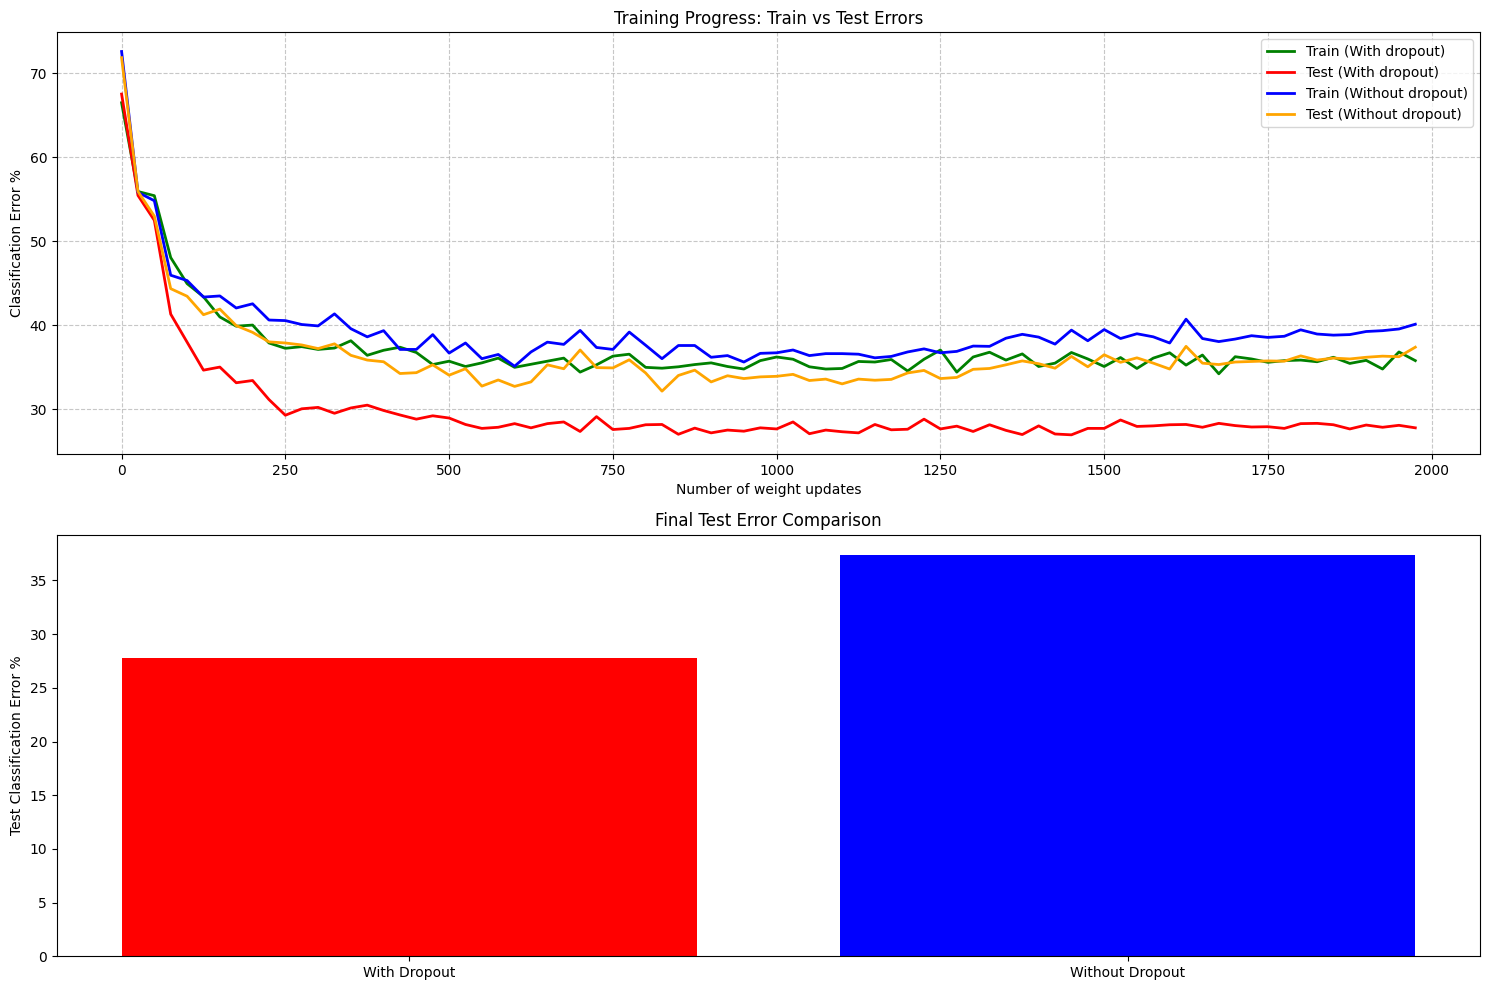


Program completed


In [124]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

def train_network(X_train, y_train, X_test, y_test, use_dropout=True, max_iterations=2000):
    # Lists to store metrics
    train_errors = []
    test_errors = []
    weight_updates = []
    
    try:
        # Initialize network
        print(f"Initializing network {'with' if use_dropout else 'without'} dropout...")
        
        # Modified architecture and hyperparameters
        dense1 = DenseLayer(2, 256, l2w=5e-4, l2b=5e-4)  # Reduced neurons, increased regularization
        activation1 = ReLu_Activation()
        dropout1 = Layer_DropOut(rate=0.2) if use_dropout else None
        dense2 = DenseLayer(256, 128)  # Added intermediate layer
        activation2 = ReLu_Activation()
        dropout2 = Layer_DropOut(rate=0.2) if use_dropout else None
        dense3 = DenseLayer(128, 3)
        loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        optimiser = Adam_Optimizer(learning_rate=0.005, decay=5e-7)  # Increased learning rate
        
        
        
        
        update_count = 0
        store_every = 25
        
        print("Starting training loop...")
        pbar = tqdm(total=max_iterations, 
                   desc=f'Training {"with" if use_dropout else "without"} dropout',
                   ncols=100)
        
        last_train_error = float('inf')
        last_test_error = float('inf')
        stuck_count = 0
        patience = 40
        min_delta = 1e-4
        
        for iteration in range(max_iterations):
            # TRAINING FORWARD PASS
            dense1.forward_pass(X_train)
            activation1.forward(dense1.output)
            
            if use_dropout:
                dropout1.forward(activation1.output)
                current_output = dropout1.output
            else:
                current_output = activation1.output
                
            dense2.forward_pass(current_output)
            activation2.forward(dense2.output)
            
            if use_dropout:
                dropout2.forward(activation2.output)
                current_output = dropout2.output
            else:
                current_output = activation2.output
                
            dense3.forward_pass(current_output)
        
            # Training Loss calculation
            data_loss = loss_activation.forward(dense3.output, y_train)
            regularisation_loss = (
                loss_activation.loss.regularization_loss(dense1) + 
                loss_activation.loss.regularization_loss(dense2)
            )
            loss = data_loss + regularisation_loss
            
            # Calculate training accuracy
            train_predictions = np.argmax(loss_activation.output, axis=1)
            y_train_compare = np.argmax(y_train, axis=1) if len(y_train.shape) == 2 else y_train
            train_error_percentage = (1 - np.mean(train_predictions == y_train_compare)) * 100
            
            # TEST FORWARD PASS (for evaluation)
            dense1.forward_pass(X_test)
            activation1.forward(dense1.output)
            dense2.forward_pass(activation1.output)
            activation2.forward(dense2.output)
            dense3.forward_pass(activation2.output)
            
            # Calculate test accuracy
            test_predictions = np.argmax(dense3.output, axis=1)
            y_test_compare = np.argmax(y_test, axis=1) if len(y_test.shape) == 2 else y_test
            test_error_percentage = (1 - np.mean(test_predictions == y_test_compare)) * 100
            
            # Store metrics
            if iteration % store_every == 0:
                # Check for convergence
                if (abs(train_error_percentage - last_train_error) < min_delta and 
                    abs(test_error_percentage - last_test_error) < min_delta):
                    stuck_count += 1
                else:
                    stuck_count = 0
                
                if stuck_count > patience:
                    print("\nTraining converged.")
                    break
                
                last_train_error = train_error_percentage
                last_test_error = test_error_percentage
                
                train_errors.append(train_error_percentage)
                test_errors.append(test_error_percentage)
                weight_updates.append(update_count)
                
                pbar.set_description(
                    f'Train Err: {train_error_percentage:.2f}% | Test Err: {test_error_percentage:.2f}% | Loss: {loss:.4f}'
                )
            
            # Backward pass with gradient clipping
            loss_activation.backward(loss_activation.output, y_train)
            dense3.back_prop(loss_activation.dinputs)
            
            if use_dropout:
                dropout2.backward(dense3.dinputs)
                activation2.back_prop(dropout2.dinputs)
            else:
                activation2.back_prop(dense3.dinputs)
                
            dense2.back_prop(activation2.dinputs)
            
            if use_dropout:
                dropout1.backward(dense2.dinputs)
                activation1.back_prop(dropout1.dinputs)
            else:
                activation1.back_prop(dense2.dinputs)
                
            dense1.back_prop(activation1.dinputs)
        
            # # Clip gradients
            # dense1.dinputs = np.clip(dense1.dinputs, -1, 1)
            # dense2.dinputs = np.clip(dense2.dinputs, -1, 1)
            # dense3.dinputs = np.clip(dense3.dinputs, -1, 1)
            
            # Update parameters
            optimiser.pre_update_params()
            optimiser.update_params(dense1)
            optimiser.update_params(dense2)
            optimiser.update_params(dense3)
            optimiser.post_update_params()
            
            
            
            
            
            
            
            update_count += 1
            pbar.update(1)
            
    except Exception as e:
        print(f"\nTraining failed: {str(e)}")
        return None, None, None, None
    finally:
        pbar.close()
        
    return weight_updates, train_errors, test_errors, last_test_error

# Visualization function
def plot_training_results(updates_with_dropout, train_errors_with_dropout, test_errors_with_dropout,
                           updates_without_dropout, train_errors_without_dropout, test_errors_without_dropout):
    plt.figure(figsize=(15, 10))
    
    # Training Errors Subplot
    plt.subplot(2, 1, 1)
    if updates_with_dropout is not None and train_errors_with_dropout is not None:
        plt.plot(updates_with_dropout, train_errors_with_dropout, 
                label='Train (With dropout)', color='green', linewidth=2)
        plt.plot(updates_with_dropout, test_errors_with_dropout, 
                label='Test (With dropout)', color='red', linewidth=2)
    if updates_without_dropout is not None and train_errors_without_dropout is not None:
        plt.plot(updates_without_dropout, train_errors_without_dropout, 
                label='Train (Without dropout)', color='blue', linewidth=2)
        plt.plot(updates_without_dropout, test_errors_without_dropout, 
                label='Test (Without dropout)', color='orange', linewidth=2)
    
    plt.xlabel('Number of weight updates')
    plt.ylabel('Classification Error %')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.title('Training Progress: Train vs Test Errors')
    
    # Final Test Error Comparison Subplot
    plt.subplot(2, 1, 2)
    final_errors = []
    final_labels = []
    
    if updates_with_dropout is not None:
        final_errors.append(test_errors_with_dropout[-1])
        final_labels.append('With Dropout')
    
    if updates_without_dropout is not None:
        final_errors.append(test_errors_without_dropout[-1])
        final_labels.append('Without Dropout')
    
    plt.bar(final_labels, final_errors, color=['red', 'blue'])
    plt.title('Final Test Error Comparison')
    plt.ylabel('Test Classification Error %')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    try:
        # Generate training and testing datasets
        X_train, y_train = spiral_data(samples=1000, classes=3)
        X_test, y_test = spiral_data(samples=1000, classes=3)
        
        print("\nAttempting training with dropout...")
        updates_with_dropout, train_errors_with_dropout, test_errors_with_dropout, _ = train_network(
            X_train, y_train, X_test, y_test, use_dropout=True
        )
        
        print("\nAttempting training without dropout...")
        updates_without_dropout, train_errors_without_dropout, test_errors_without_dropout, _ = train_network(
            X_train, y_train, X_test, y_test, use_dropout=False
        )
        
        plot_training_results(
            updates_with_dropout, train_errors_with_dropout, test_errors_with_dropout,
            updates_without_dropout, train_errors_without_dropout, test_errors_without_dropout
        )
        
    except Exception as e:
        print(f"\nProgram failed: {str(e)}")
    finally:
        print("\nProgram completed")

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys



def train_network(use_dropout=True, max_iterations=2000):
    # Lists to store metrics
    errors = []
    weight_updates = []
    
    try:
        # Initialize network
        print("Initializing network...")
        X, y = spiral_data(samples=1000, classes=3)
        
        # Modified architecture and hyperparameters
        dense1 = DenseLayer(2, 256, l2w=5e-4, l2b=5e-4)  # Reduced neurons, increased regularization
        activation1 = ReLu_Activation()
        dropout1 = Layer_DropOut(rate=0.2) if use_dropout else None  # More reasonable dropout rate (30%)
        dense2 = DenseLayer(256, 128)  # Added intermediate layer
        activation2 = ReLu_Activation()
        dropout2 = Layer_DropOut(rate=0.2) if use_dropout else None  # Second dropout layer
        dense3 = DenseLayer(128, 3)
        loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        optimiser = Adam_Optimizer(learning_rate=0.005, decay=5e-7)  # Increased learning rate
        
        update_count = 0
        store_every = 25
        
        print("Starting training loop...")
        pbar = tqdm(total=max_iterations, 
                   desc=f'Training {"with" if use_dropout else "without"} dropout',
                   ncols=100)
        
        last_error = float('inf')
        stuck_count = 0
        patience = 40  # Increased patience for stuck detection
        min_delta = 1e-4  # Reduced sensitivity for stuck detection
        
        for iteration in range(max_iterations):
            # Forward pass with gradient clipping
            dense1.forward_pass(X)
            activation1.forward(dense1.output)
            
            if use_dropout:
                dropout1.forward(activation1.output)
                current_output = dropout1.output
            else:
                current_output = activation1.output
                
            dense2.forward_pass(current_output)
            activation2.forward(dense2.output)
            
            if use_dropout:
                dropout2.forward(activation2.output)
                current_output = dropout2.output
            else:
                current_output = activation2.output
                
            dense3.forward_pass(current_output)
        
            # Loss calculation
            data_loss = loss_activation.forward(dense3.output, y)
            regularisation_loss = (
                loss_activation.loss.regularization_loss(dense1) + 
                loss_activation.loss.regularization_loss(dense2)
            )
            loss = data_loss + regularisation_loss
            
            # Calculate accuracy
            predictions = np.argmax(loss_activation.output, axis=1)
            y_compare = np.argmax(y, axis=1) if len(y.shape) == 2 else y
            error_percentage = (1 - np.mean(predictions == y_compare)) * 100
            
            # Store metrics
            if iteration % store_every == 0:
                if abs(error_percentage - last_error) < min_delta:
                    stuck_count += 1
                else:
                    stuck_count = 0
                
                if stuck_count > patience:
                    print("\nTraining converged. Final error:", error_percentage)
                    break
                
                last_error = error_percentage
                errors.append(error_percentage)
                weight_updates.append(update_count)
                
                pbar.set_description(
                    f'Error: {error_percentage:.2f}% | Loss: {loss:.4f} | LR: {optimiser.current_learning_rate:.6f}'
                )
            
            # Backward pass with gradient clipping
            loss_activation.backward(loss_activation.output, y)
            dense3.back_prop(loss_activation.dinputs)
            
            if use_dropout:
                dropout2.backward(dense3.dinputs)
                activation2.back_prop(dropout2.dinputs)
            else:
                activation2.back_prop(dense3.dinputs)
                
            dense2.back_prop(activation2.dinputs)
            
            if use_dropout:
                dropout1.backward(dense2.dinputs)
                activation1.back_prop(dropout1.dinputs)
            else:
                activation1.back_prop(dense2.dinputs)
                
            dense1.back_prop(activation1.dinputs)
        
            
            # Clip gradients
            dense1.dinputs = np.clip(dense1.dinputs, -1, 1)
            dense2.dinputs = np.clip(dense2.dinputs, -1, 1)
            dense3.dinputs = np.clip(dense3.dinputs, -1, 1)
            # Update parameters
            optimiser.pre_update_params()
            optimiser.update_params(dense1)
            optimiser.update_params(dense2)
            optimiser.update_params(dense3)
            optimiser.post_update_params()
            
            update_count += 1
            pbar.update(1)
            
    except Exception as e:
        print(f"\nTraining failed: {str(e)}")
        return None, None
    finally:
        pbar.close()
        
    return weight_updates, errors

# Visualization function
def plot_training_results(updates_with_dropout, errors_with_dropout, 
                         updates_without_dropout, errors_without_dropout):
    plt.figure(figsize=(12, 7))
    if updates_with_dropout is not None and errors_with_dropout is not None:
        plt.plot(updates_with_dropout, errors_with_dropout, 
                label='With dropout', color='black', linewidth=2)
    if updates_without_dropout is not None and errors_without_dropout is not None:
        plt.plot(updates_without_dropout, errors_without_dropout, 
                label='Without dropout', color='blue', linewidth=2)
    
    plt.xlabel('Number of weight updates')
    plt.ylabel('Classification Error %')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.title('Training Progress: With vs Without Dropout')
    
    plt.xlim(0, max(len(updates_with_dropout or []), 
                    len(updates_without_dropout or []), 
                    1000))  # Dynamic x-axis limit
    plt.ylim(0, max(max(errors_with_dropout or [0]), 
                    max(errors_without_dropout or [0]), 
                    20))  # Dynamic y-axis limit
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    try:
        print("\nAttempting training with dropout...")
        updates_with_dropout, errors_with_dropout = train_network(use_dropout=True)
        
        print("\nAttempting training without dropout...")
        updates_without_dropout, errors_without_dropout = train_network(use_dropout=False)
        
        plot_training_results(updates_with_dropout, errors_with_dropout,
                            updates_without_dropout, errors_without_dropout)
        
    except Exception as e:
        print(f"\nProgram failed: {str(e)}")
    finally:
        print("\nProgram completed")


Attempting training with dropout...
Initializing network...
Starting training loop...


Error: 14.03% | Loss: 0.3658 | LR: 0.004999:  19%|██▉            | 385/2000 [00:14<01:02, 26.04it/s]


Program completed


KeyboardInterrupt: 